In [1]:
%reload_ext autoreload
%autoreload 2

# Load packages and data

In [2]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from elections import constants
from elections.results_reporting import (load_sentiments, plot_articles_by_publishers, 
    expand_sentiments, load_errors, get_article_score_stats,
    plot_politician_article_refs, plot_politician_daily_article_refs, clean_data,
)

In [3]:
compact_df = load_sentiments()
load_errors(counts_only=True)

03/09/2024 03:40:23 PM - Loaded 5596 sentiments from the database.
03/09/2024 03:40:23 PM - There are 1078 errors in the last sentiment analysis run of all articles


In [4]:
expanded_df = expand_sentiments(compact_df)
expanded_df = clean_data(expanded_df)
complete_df = pd.merge(expanded_df, compact_df[["article_id", "pubdate", "publisher"]], on='article_id')
get_article_score_stats(complete_df)

,n
articles_with_score,3116
articles_without_score,1962


# Publisher representation

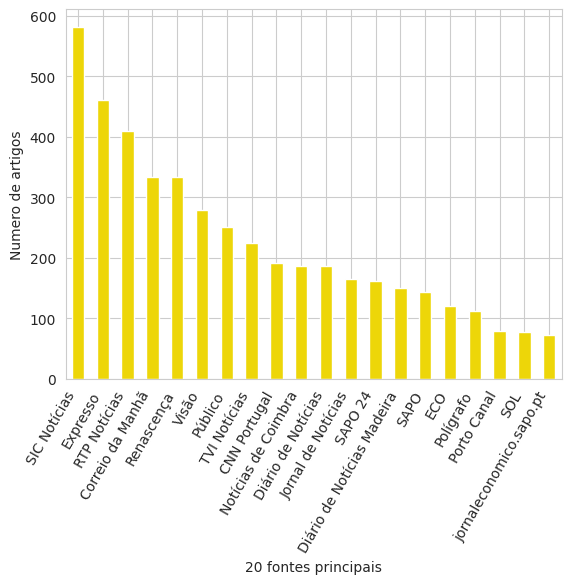

In [115]:
plot_articles_by_publishers(compact_df, 20)

# Politician resepresentation in data

name
Luís Montenegro       0.247501
Pedro Nuno Santos     0.201614
André Ventura         0.163676
Mariana Mortágua      0.102011
Rui Rocha             0.084668
Paulo Raimundo        0.073708
Rui Tavares           0.068650
Inês de Sousa Real    0.058172
Name: article_id, dtype: float64


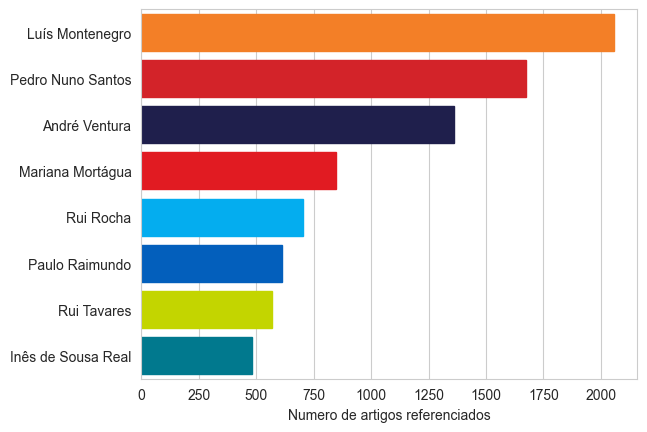

In [116]:
plot_politician_article_refs(expanded_df)

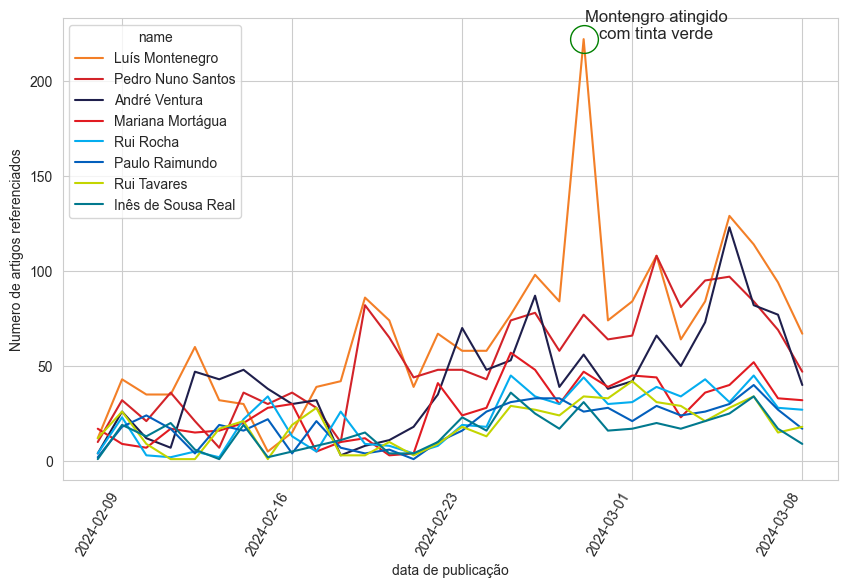

In [117]:
plot_politician_daily_article_refs(complete_df)

* an analysis of how favourable each of the major outlets is to each candidate
* show if an outlet is left leaning or right leaning
* 

In [65]:
politician_avg_scores = (
    complete_df
    .groupby("name")["score"]
    .mean()
    #.reset_index()
)
politician_avg_scores.sort_values(ascending=False, inplace=True)
politician_avg_scores

name
Mariana Mortágua      0.676563
Paulo Raimundo        0.675168
Rui Rocha             0.614815
Inês de Sousa Real    0.612963
Rui Tavares           0.609252
Pedro Nuno Santos     0.554555
André Ventura         0.464294
Luís Montenegro       0.455563
Name: score, dtype: float64

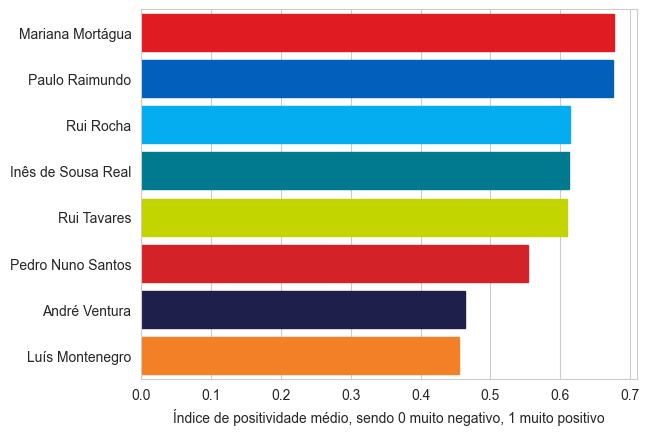

In [121]:
colors = [
    constants.POLITICIAN_COLORS[name] for name in politician_avg_scores.index
]
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        politician_avg_scores, 
        orient = 'h',
    )
    plt.xlabel("Índice de positividade médio, sendo 0 muito negativo, 1 muito positivo")
    plt.ylabel("")
    for i, bar in enumerate(ax.patches):
        bar.set_color(colors[i])
    plt.show()

In [47]:
def mean_plot(*args, **kwargs):
    data = kwargs.pop("data")
    x_col = kwargs.pop("x")
    ymin = kwargs.pop("ymin")
    ymax = kwargs.pop("ymax")
    return plt.vlines(data[x_col].mean(), ymin=ymin, ymax=ymax, **kwargs)



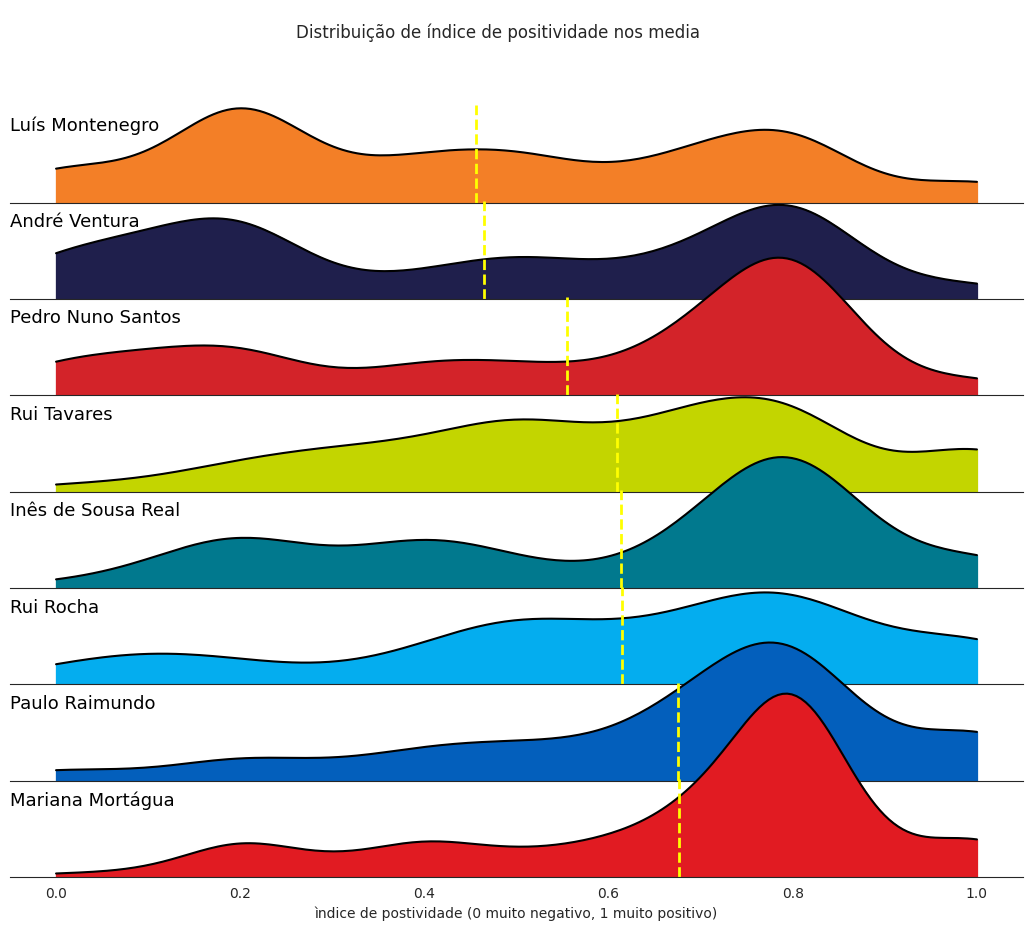

In [122]:
#sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

row_order = politician_avg_scores.reset_index()["name"].tolist()[::-1]

colors = [constants.POLITICIAN_COLORS[name] for name in row_order]
palette = sns.set_palette(sns.color_palette(colors))

with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2}):
    g = sns.FacetGrid(
        complete_df[~complete_df.score.isnull()], 
        palette=palette, row="name", hue="name",
        hue_order=row_order, row_order=row_order, aspect=9, height=1.2
    )

    g.map_dataframe(sns.kdeplot, x="score", color='black', cut=0)
    g.map_dataframe(sns.kdeplot, x="score", fill=True, alpha=1, cut=0)
    g.map_dataframe(mean_plot, x="score", ymin=0, ymax=1.7, linewidth=2, color="yellow", linestyle="--")

    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0, .4, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes
        )

    g.map(label, "score")
    g.figure.subplots_adjust(hspace=-0.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="ìndice de postividade (0 muito negativo, 1 muito positivo)", ylabel="")
    g.despine( left=True)
    plt.suptitle('Distribuição de índice de positividade nos media', y=0.95)

In [107]:
mask = (complete_df.pubdate >= datetime(2024, 2, 8)) & (complete_df.pubdate <= datetime(2024, 3, 9))
daily_scores_feb = complete_df[mask].groupby(["pubdate", "name"])["score"].mean().reset_index()
#daily_scores_feb.sort_values(["politician", "pubdate"], inplace=True)
daily_scores_feb

,pubdate,name,score
0,2024-02-08 08:00:00,André Ventura,0.733333
1,2024-02-08 08:00:00,Inês de Sousa Real,0.800000
2,2024-02-08 08:00:00,Luís Montenegro,0.390000
3,2024-02-08 08:00:00,Mariana Mortágua,0.676190
4,2024-02-08 08:00:00,Paulo Raimundo,NaN
...,...,...,...
4724,2024-03-08 23:26:00,Rui Rocha,0.500000
4725,2024-03-08 23:26:12,André Ventura,0.000000
4726,2024-03-08 23:38:33,Rui Tavares,1.000000
4727,2024-03-08 23:39:00,Paulo Raimundo,NaN


In [113]:
def interpolate_date(df, window_size=10):
    df_ = df[["pubdate", "score"]].copy()
    df_.set_index("pubdate", inplace=True)
    dates = pd.date_range(start=df["pubdate"].min(), end=df["pubdate"].max(), freq='D')
    df_ = df_.reindex(dates)
    df_.index.rename(name="pubdate", inplace=True)
    df_["score_filled"] = (df_["score"].bfill() + df_["score"].ffill()) / 2
    df_["score_smooth"] = df_["score_filled"].rolling(window_size, min_periods=1).mean()
    return df_


#from datetime import datetime
#mask = (complete_df.pubdate >= datetime(2024, 2, 8)) & (complete_df.pubdate <= datetime(2024, 2, 9))
daily_smooth_scores = daily_scores_feb.groupby("name").apply(interpolate_date).reset_index()
daily_smooth_scores

,name,pubdate,score,score_filled,score_smooth
0,André Ventura,2024-02-08 08:00:00,0.733333,0.733333,0.733333
1,André Ventura,2024-02-09 08:00:00,0.517647,0.517647,0.625490
2,André Ventura,2024-02-10 08:00:00,0.675000,0.675000,0.641993
3,André Ventura,2024-02-11 08:00:00,0.342857,0.342857,0.567209
4,André Ventura,2024-02-12 08:00:00,0.289655,0.289655,0.511699
...,...,...,...,...,...
235,Rui Tavares,2024-03-04 08:00:00,NaN,NaN,0.704285
236,Rui Tavares,2024-03-05 08:00:00,NaN,NaN,0.730356
237,Rui Tavares,2024-03-06 08:00:00,NaN,NaN,0.654510
238,Rui Tavares,2024-03-07 08:00:00,NaN,NaN,0.691765


<Axes: xlabel='pubdate', ylabel='score_smooth'>

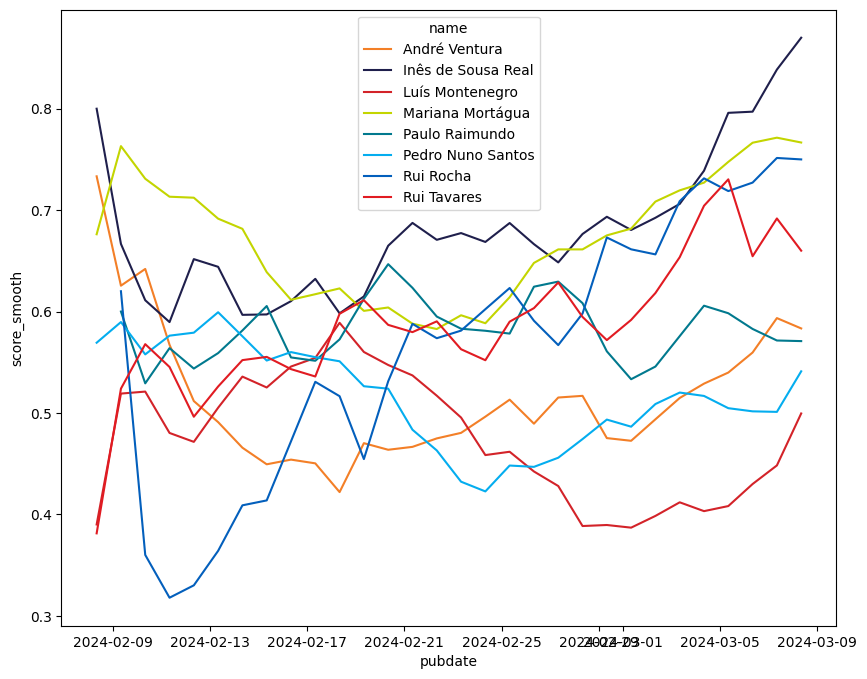

In [114]:
fig = plt.figure(figsize=(10, 8))
sns.lineplot(
    data=daily_smooth_scores,
    x="pubdate", y="score_smooth", hue="name"
)